Import necessary libraries

In [1]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from matplotlib import pyplot

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

Read and resize image. We need both content image and style image to be the same size.

In [2]:
MAX_W = 400 
MAX_H = 400
def read_img(path):
  img = io.imread(path)
  # resize if image is large
  if img.shape[0] > MAX_H and img.shape[1] > MAX_W:
    img = resize(img, (MAX_W, MAX_H))  # resize and scale from [0,255] to [0,1]
  return img

def show_image(tensor, title=None):
    image = tensor.cpu().detach().numpy()  # use clone to return a copy of tensor
    # now shape: 1 * 3 * 400 * 400
    image = image.squeeze()      # remove the batch dimension to make the image 3-dimensions
    # now shape: 3 * 400 * 400
    image = np.transpose(image, (1,2,0))
    # now shape: 512 * 512 * 3, 3 represent RGB channels
    plt.imshow(image)
    if title is not None: plt.title(title)

The input image dimension is (H, W, C). 
H: height 
W: weight
C: channel

We want to reshape it in the favor of pytorch format input as (C, H, W) Later on training, we add B as Batch to the input data to form the 4-D dimension as (B,C,H,W), this is consistent with model formatting in PyTorch


In [3]:
# change image path here for different test cases
content_img = read_img("/content/dancing.jpg")
style_img = read_img("/content/picasso.jpg")

print(f'Shape of content img: {content_img.shape}')
print(f'Shape of style img: {style_img.shape}')
print(f'Content image channel values at first pixel position: {content_img[0, 0, :]}')
print(f'Style image channel values at first pixel position: {style_img[0, 0, :]}')

# convert from (H, W, C) format to (C, H, W)
content = np.transpose(content_img, (2,0,1))  # transpose the dimension by setting third Dimension first
style = np.transpose(style_img, (2,0,1))
# convert numpy to torch
content = torch.from_numpy(content)
style = torch.from_numpy(style)

print('-------------------After Conversion:')
print(f'Shape of content img: {content.shape}')
print(f'Shape of style img: {style.shape}')
print(f'Content image channel values at first pixel position: {content[:, 0, 0]}')
print(f'Style image channel values at first pixel position: {style[:, 0, 0]}')

Shape of content img: (400, 400, 3)
Shape of style img: (400, 400, 3)
Content image channel values at first pixel position: [0.17317235 0.15356451 0.1300351 ]
Style image channel values at first pixel position: [0.18053002 0.2589614  0.28763787]
-------------------After Conversion:
Shape of content img: torch.Size([3, 400, 400])
Shape of style img: torch.Size([3, 400, 400])
Content image channel values at first pixel position: tensor([0.1732, 0.1536, 0.1300], dtype=torch.float64)
Style image channel values at first pixel position: tensor([0.1805, 0.2590, 0.2876], dtype=torch.float64)


show image


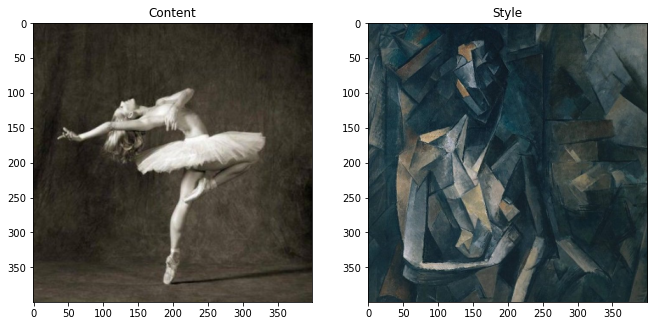

In [4]:
fig = plt.figure(figsize=(11,11))
plt.subplot(1,2,1)
plt.imshow(content_img),plt.title('Content')
plt.subplot(1,2,2)
plt.imshow(style_img),plt.title('Style')
print('show image')

**Now We define some useful classes and functions to facilitate the development of our application**

Hook mechanism: functions that automatically execute after a particular event.

We use it for several purposes:


1.   Debuggin 
2.   Feature Extraction
3.   Gradient Clipping



PyTorch hooks are registered for each Tensor or nn.Module object and are triggered by either the forward or backward pass of the object. The forward hook will be executed when a forward call is executed. Here we use forward hook to capture the feature maps at intermediate layers of VGG net.


Helpful links: 


1.   https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904
2.   https://www.kaggle.com/sironghuang/understanding-pytorch-hooks


In [5]:
# Define hook class which stores forward pass outputs of vgg using a forward hook
class SaveFeatures():
  def __init__(self, module):
    self.hook = module.register_forward_hook(self.hook_fn)
    self.features = None
  def hook_fn(self, module, input, output):
    self.features = output # same the output feature map
  def close(self):
    self.hook.remove()

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# get vgg model
MODEL = 'vgg19'
f = getattr(models, MODEL)
vgg = f(pretrained = True)

# get vgg model's parameters only in the Conv layer and freeze the weights
net = vgg.features
for p in net.parameters():
  p.requires_grad = False

# put our net model to GPU
net.to(device)
# look at the structure of vgg net
print(net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

**Now we pick the layers and register forward hook for content image and style image**


`content[None] ` means we add a batch (size=1) dimension to our image
`style[None]` menas we add a btach (size=1) dimension to our image

By this way, we change the image data dimension to (B, C, H, W)

Finally, we need to normalize the input image as all pre-trained models expect input images normalized in the same way

[Reference about normalization for VGG](https://https://pytorch.org/hub/pytorch_vision_vgg/)



In [6]:
# pass content and style images to GPU
content = content.to(device)
style = style.to(device)
# content hook
layers_content = ['5', '12','22']
cnt_hooks = [SaveFeatures(net._modules[i]) for i in layers_content]  # register hooks on target layers
# style hook
layers_style = ['5', '12', '22', '32', '35']
sty_hooks = [SaveFeatures(net._modules[i]) for i in layers_style]  # register hooks on target layers


# convert input image size to 4-D by adding Batch size = 1, use Variable to wrap the tensor for auto grad
net(Variable(content[None].type(torch.cuda.FloatTensor)))  # pass content image through the net
cnt_features = [f.features.clone() for f in cnt_hooks]

net(Variable(style[None].type(torch.cuda.FloatTensor)))    # pass style image through the net
sty_features = [s.features.clone() for s in sty_hooks]


Notice: cnt_hooks and sty_hooks won't have the self.features attributes until we pass the value through the net.

The reason is that the forward hook can only capture the feature maps once we call the forward method

**After extracting out feature maps, we can visualize what kind of features the VGG nets capture at different layers. Here I won't show the details of visualization for feature maps but see the comments for my observations**

**Comments:**

We can see that the feature maps closer to the input of the model capture a lot of fine detail in the image and that as we progress deeper into the model, the feature maps show less and less detail. The deeper the layers are, the abstract the features are captured, which make senses to the idea of CNN network. (we summarize the very important features that can be used for tasks such as classfication as going to the deeper layers. )



---




Now we have stored the content image features for some intermediate layers and style image features for some 
intermediate layers 

**Next step is to build an input image and start our training**

**Define closure for LBFGS optimizer and other loss functions according to the paper**

Some optimization algorithms such as Conjugate Gradient and LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model. The closure should clear the gradients, compute the loss, and return it

In [7]:
# content loss function
def content_loss(yhat):
  l = 0
  for i in range(len(yhat)):
    l += MSE(cnt_features[i], yhat[i])  # add all layers losses
  return l
  
# gram for style loss
def gram_matrix(x):
  b,c,h,w = x.shape
  x = x.view(b*c, h*w)  # flatten the feature map to a feature vector along each channel
  G = torch.mm(x, x.t())  # compute dot product of every feature vector with each other 
  return G 
# style loss function
def style_loss(yhat):
  l = 0
  for i in range(len(yhat)):
    style_gram = gram_matrix(sty_features[i])
    syn_gram = gram_matrix(yhat[i])  
    l += MSE(style_gram, syn_gram)  # add all layers losses
  return l

# used for optimizer
def closure():
  global i

  optimizer.zero_grad()  # avoid accumlating the gradient by setting it to zero every time
  net(input_img) # pass input image through the VGG net
  cnt_input_features = [f.features.clone() for f in cnt_hooks] # use the content hook to return the input content features
  sty_input_features = [s.features.clone() for s in sty_hooks] # use the style hook to return the input style features
  cnt_loss, sty_loss = content_loss(cnt_input_features), style_loss(sty_input_features)

  loss = alpha * cnt_loss + beta * sty_loss
  loss.backward()  # compute the gradient

  if i % 50 == 0:
    print('Step - {}, Content loss - {}, Style loss - {}, Total loss - {}' \
          .format(i, cnt_loss.item(), sty_loss.item(), loss.item()))
    # out_img = input_img.data.cpu().squeeze().permute(1,2,0)
    output_list.append(input_img)

  i += 1
  return loss
  

**Start Training**

Experiment on original content image

In [8]:
synthesis_img = torch.tensor(content_img).detach()
synthesis = np.transpose(synthesis_img, (2,0,1))  # transpose to dimension as (C, H, W)
synthesis = scipy.ndimage.filters.median_filter(synthesis, [8,8,1]) # reduce noise to improve image processing
synthesis = torch.from_numpy(synthesis) # convert to tensor
synthesis = synthesis.to(device)  # pass to gpu
synthesis = Variable(synthesis[None].type(torch.cuda.FloatTensor),requires_grad=True) # create Variable to wrap the tensor
input_img =synthesis

print(f'Shape: {input_img.shape}')

Shape: torch.Size([1, 3, 400, 400])


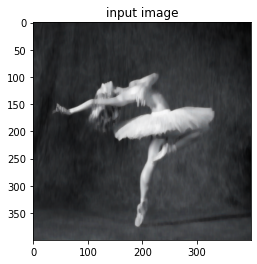

In [9]:
show_image(input_img, 'input image')

In [10]:
%%time

STEPS = 300
l_r = 1
optimizer = torch.optim.LBFGS([input_img],lr=l_r)
MSE = nn.MSELoss() 
alpha = 100   # content weight
beta = 1e6   # style weight
output_list = []
print('Training...')

i = 0
while i < STEPS:
  optimizer.step(closure)


# store the intermediate input image in a list for result checking and debugging.
# Since this is a float image, clamp pixel value between 0 and 1. Define a function to convert tensor to output image
output_list = [torch.clamp(im, min=0, max=1) for im in output_list]

Training...
Step - 0, Content loss - 0.5478647947311401, Style loss - 35472248.0, Total loss - 35472248143872.0
Step - 50, Content loss - 2.6567301750183105, Style loss - 75985.2734375, Total loss - 75985272832.0
Step - 100, Content loss - 2.779827117919922, Style loss - 29876.189453125, Total loss - 29876189184.0
Step - 150, Content loss - 2.8551206588745117, Style loss - 18431.7578125, Total loss - 18431758336.0
Step - 200, Content loss - 2.902740478515625, Style loss - 13791.6318359375, Total loss - 13791631360.0
Step - 250, Content loss - 2.9373831748962402, Style loss - 11230.916015625, Total loss - 11230915584.0
CPU times: user 13.9 s, sys: 7.17 s, total: 21.1 s
Wall time: 21.1 s


Comments: The loss for content loss should be decreased but in fact it doesn't. We pass the copy of content image into the VGG net, which will result very small difference in content structure, but this should not be the reason to cause loss increase. I guess the issue is because of computing loss seperately, even though it doesn't hurt the final result but should notice here. 

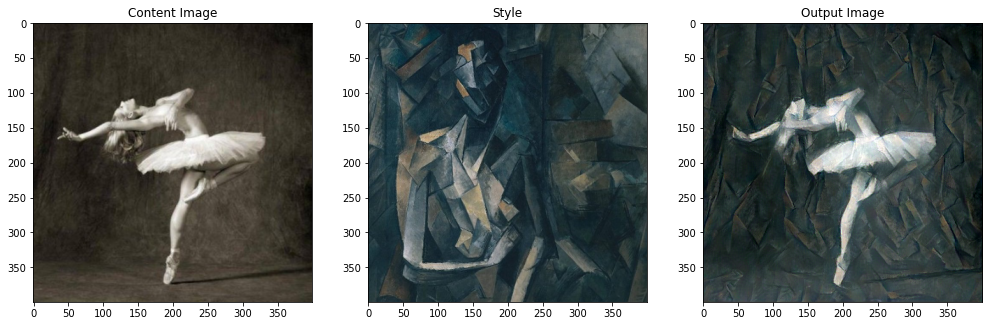

In [11]:
fig = plt.figure(figsize=(17,17))

plt.subplot(1,3,1)
plt.imshow(content_img),plt.title('Content Image')

plt.subplot(1,3,2)
plt.imshow(style_img),plt.title('Style')

plt.subplot(1,3,3)
show_image(torch.clamp(input_img, min=0, max=1), 'Output Image')

In [12]:
# fig = plt.figure(figsize=(5,5))
# plt.axis('off')
# plt.imshow(content_img),plt.title('horse')

# fig = plt.figure(figsize=(5,5))
# plt.axis('off')
# plt.imshow(style_img),plt.title('Starry night')


# fig = plt.figure(figsize=(5,5))
# plt.axis('off')
# show_image(torch.clamp(input_img, min=0, max=1), 'starry night style')

Experiment on white noise image

In [13]:
# # Input noise image and train this image
synthesis_img = np.random.uniform(0.0, 1.0, size=content_img.shape)
synthesis = np.transpose(synthesis_img, (2,0,1))  # transpose to dimension as (C, H, W)
synthesis = scipy.ndimage.filters.median_filter(synthesis, [8,8,1]) # reduce noise to improve image processing
synthesis = torch.from_numpy(synthesis) # convert to tensor
synthesis = synthesis.to(device)  # pass to gpu
synthesis = Variable(synthesis[None].type(torch.cuda.FloatTensor),requires_grad=True) # create Variable to wrap the tensor
input_img =synthesis

print(f'Shape: {input_img.shape}')

Shape: torch.Size([1, 3, 400, 400])


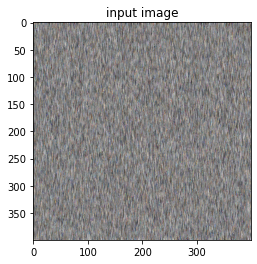

In [14]:
show_image(input_img, 'input image')

In [15]:
%%time

STEPS = 300
l_r = 1
optimizer = torch.optim.LBFGS([input_img],lr=l_r)
MSE = nn.MSELoss() 
alpha = 1e7  # content weight
beta = 10  # style weight

output_list = []
print('Training...')

i = 0
while i < STEPS:
  optimizer.step(closure)


# Since this is a float image, clamp pixel value between 0 and 1. Define a function to convert tensor to output image
output_list = [torch.clamp(im, min=0, max=1) for im in output_list]

Training...
Step - 0, Content loss - 5.474278450012207, Style loss - 480168896.0, Total loss - 4856431616.0
Step - 50, Content loss - 2.051323890686035, Style loss - 476414.28125, Total loss - 25277380.0
Step - 100, Content loss - 1.5145293474197388, Style loss - 339294.53125, Total loss - 18538238.0
Step - 150, Content loss - 1.305276870727539, Style loss - 310087.21875, Total loss - 16153641.0
Step - 200, Content loss - 1.2019520998001099, Style loss - 296334.34375, Total loss - 14982864.0
Step - 250, Content loss - 1.1358058452606201, Style loss - 288191.09375, Total loss - 14239969.0
CPU times: user 14.1 s, sys: 7.24 s, total: 21.3 s
Wall time: 21.4 s


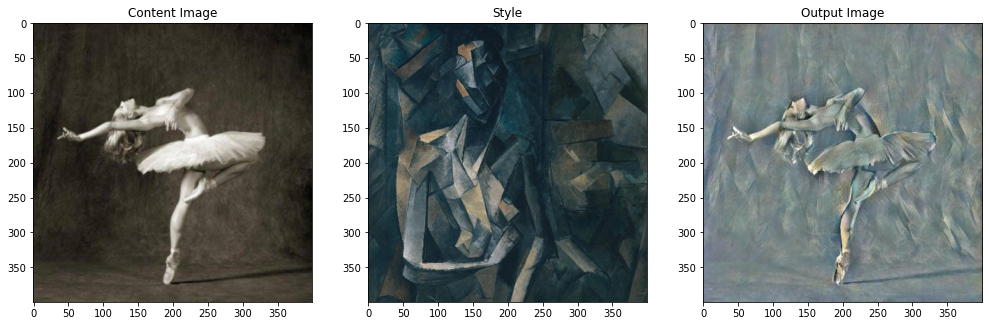

In [16]:
fig = plt.figure(figsize=(17,17))

plt.subplot(1,3,1)
plt.imshow(content_img),plt.title('Content Image')

plt.subplot(1,3,2)
plt.imshow(style_img),plt.title('Style')

plt.subplot(1,3,3)
show_image(torch.clamp(input_img, min=0, max=1), 'Output Image')



---






In [17]:
# file_name = 'stylized-image.png'
# tensor_to_image(torch.clamp(torch.tensor(output_list[4]), min=0, max=1)).save(file_name)

# try:
#   from google.colab import files
# except ImportError:
#    pass
# else:
#   files.download(file_name)